In [2]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torchvision.models as models
from torch.autograd import Variable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os, shutil
import glob
import cv2
import warnings
warnings.filterwarnings('ignore')

# Ensures inline plotting
%matplotlib inline

In [3]:
df = pd.read_csv(r"E:\Projets\Datasets - Pytorch\Age Dataset\faces\train.csv")
df

,ID,Class
0,377.jpg,MIDDLE
1,17814.jpg,YOUNG
2,21283.jpg,MIDDLE
3,16496.jpg,YOUNG
4,4487.jpg,MIDDLE
...,...,...
19901,2482.jpg,MIDDLE
19902,20085.jpg,YOUNG
19903,19663.jpg,MIDDLE
19904,10132.jpg,MIDDLE


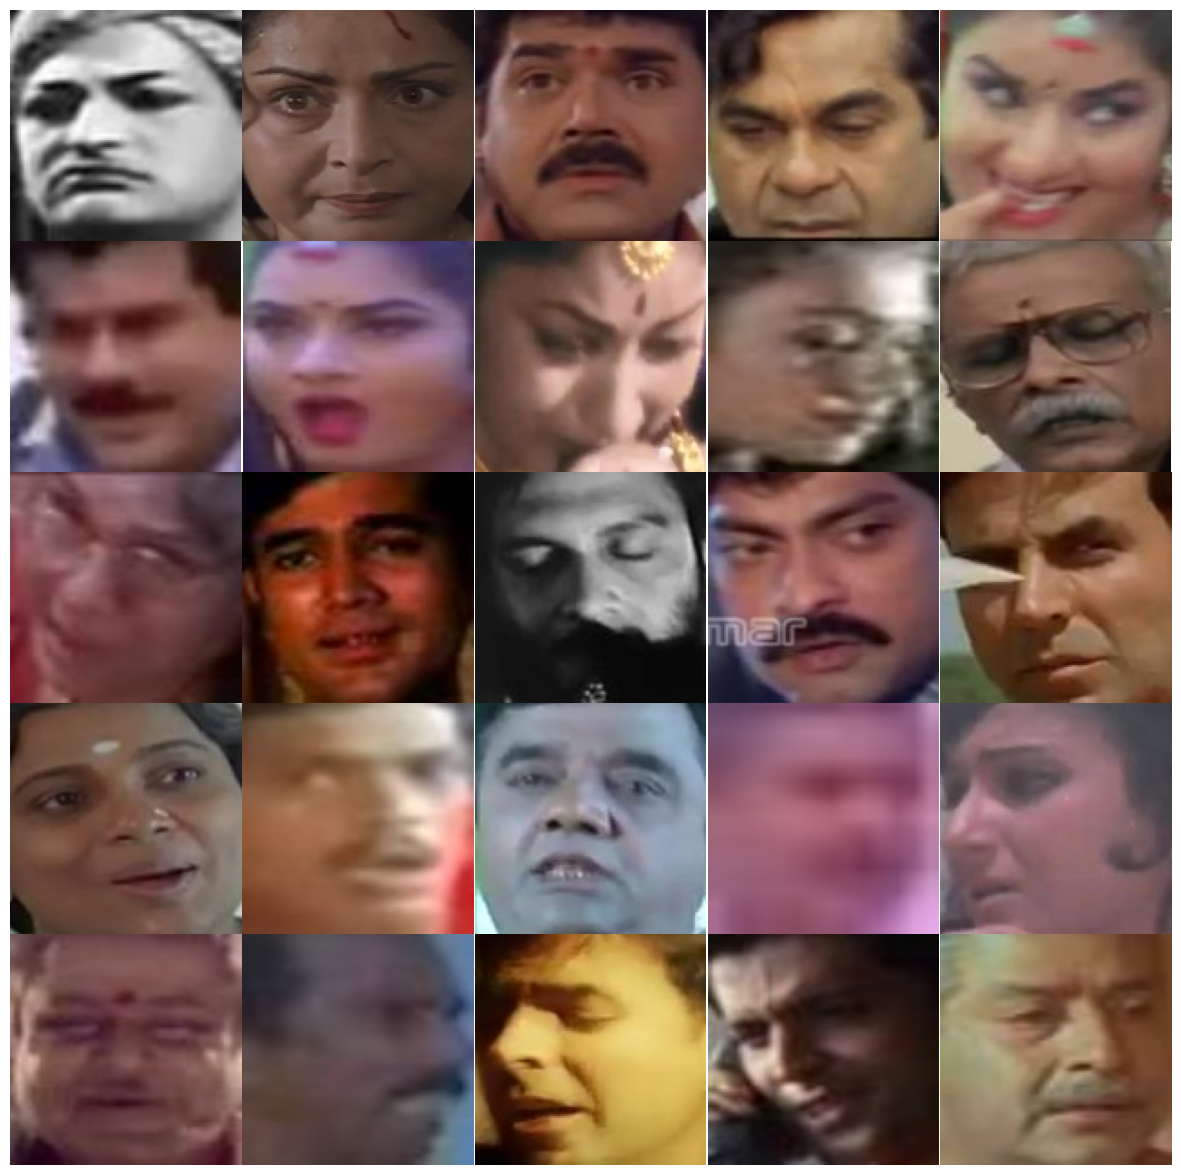

In [6]:
multipleImages = glob.glob(r"E:\Projets\Datasets - Pytorch\Age Dataset\faces\Train\**")
i_ = 0
plt.rcParams['figure.figsize'] = (15.0, 15.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in multipleImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (128, 128)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

In [32]:
import pandas as pd
import os
import torch
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv(r"E:\Projets\Datasets - Pytorch\Age Dataset\faces\train.csv")  # Change this to the path of your CSV file

# Convert string labels to integer labels
label_encoder = LabelEncoder()
df['Class'] = label_encoder.fit_transform(df['Class'])

num_samples = int(len(df) * 0.2)

# Use only the first 20% of the data
df = df.sample(n=num_samples, random_state=42)

# Split the dataset
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['Class'])
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42, stratify=temp_df['Class'])

# Define the Dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(IMAGE_DIR, self.dataframe.iloc[idx]['ID'])
        image = Image.open(img_name)
        label = self.dataframe.iloc[idx]['Class']
        
        if self.transform:
            image = self.transform(image)

        # Convert label to tensor of long type
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

# Data transformations
data_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets and dataloaders
train_dataset = ImageDataset(train_df, transform=data_transforms)
val_dataset = ImageDataset(val_df, transform=data_transforms)
test_dataset = ImageDataset(test_df, transform=data_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [34]:
import torch
model = torch.hub.load('pytorch/vision:v0.10.0', 'googlenet', pretrained=True)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

print(model)

Using cache found in C:\Users\Shaikh Abdul Rafay/.cache\torch\hub\pytorch_vision_v0.10.0


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [33]:
print(len(train_loader.dataset))


3184


In [35]:
# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Early stopping and epochs
eps = 20
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(eps):
    train_correct = 0
    train_total = 0
    running_loss = 0

    model.train()

    for image, label in train_loader:
        label = label.type(torch.LongTensor)
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)

        loss = criterion(outputs, label)
        l1_norm = sum(p.abs().sum() for p in model.parameters())
        loss += 0.01 * l1_norm

        _, predicted = torch.max(outputs.data, 1)
        train_total += label.size(0)
        train_correct += (predicted == label).sum().item()

        loss.backward()
        running_loss += loss.item()
        optimizer.step()

    avg_training_loss = running_loss / len(train_loader)
    train_accuracy = (train_correct / train_total)
    train_losses.append(avg_training_loss)
    train_accuracies.append(train_accuracy)

    val_correct = 0
    val_total = 0
    val_running_loss = 0

    model.eval()
    with torch.no_grad():
        for image, label in val_loader:
            label = label.type(torch.LongTensor)
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            loss = criterion(outputs, label)
            val_running_loss += loss.item()  

            _, predicted = torch.max(outputs.data, 1)
            val_total += label.size(0)
            val_correct += (predicted == label).sum().item()

    avg_val_loss = val_running_loss / len(val_loader)  
    val_accuracy = (val_correct / val_total)

    val_accuracies.append(val_accuracy)
    val_losses.append(avg_val_loss)

    # Print results
    print(f'Epoch: {epoch}, Train Loss: {avg_training_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')


Epoch: 0, Train Loss: 1844.4085, Train Accuracy: 0.25%, Val Loss: 2.7782, Val Accuracy: 0.62%
Epoch: 1, Train Loss: 1376.9864, Train Accuracy: 0.60%, Val Loss: 1.4622, Val Accuracy: 0.65%
Epoch: 2, Train Loss: 1035.1917, Train Accuracy: 0.63%, Val Loss: 1.2368, Val Accuracy: 0.68%
Epoch: 3, Train Loss: 787.9863, Train Accuracy: 0.64%, Val Loss: 1.1336, Val Accuracy: 0.67%
Epoch: 4, Train Loss: 610.3946, Train Accuracy: 0.64%, Val Loss: 1.1877, Val Accuracy: 0.63%
Epoch: 5, Train Loss: 482.8369, Train Accuracy: 0.64%, Val Loss: 1.2062, Val Accuracy: 0.60%
Epoch: 6, Train Loss: 390.8553, Train Accuracy: 0.64%, Val Loss: 1.0949, Val Accuracy: 0.61%
Epoch: 7, Train Loss: 323.9472, Train Accuracy: 0.62%, Val Loss: 1.0981, Val Accuracy: 0.62%


KeyboardInterrupt: 

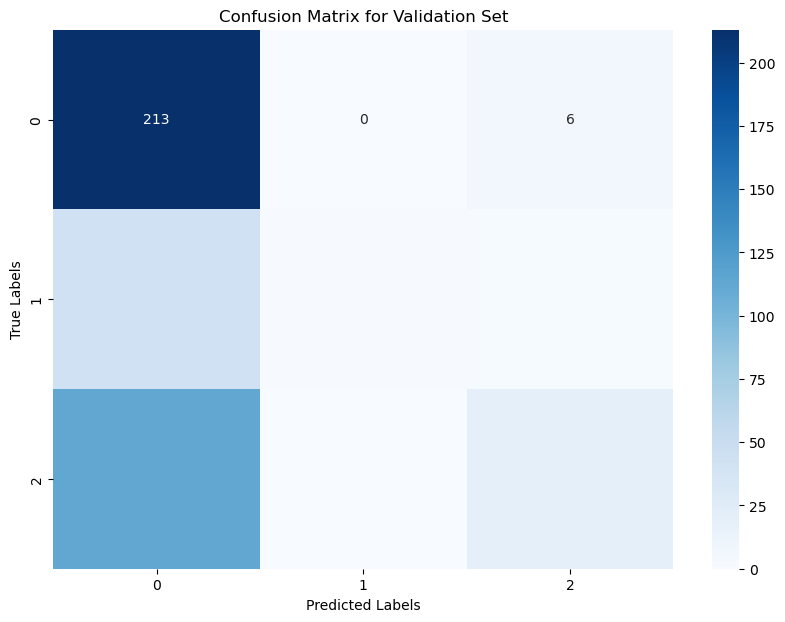

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store predictions and actual labels
all_preds = []
all_labels = []

# Switch model to evaluation mode
model.eval()
with torch.no_grad():
    for image, label in test_loader:
        if torch.cuda.is_available():
            image, label = image.cuda(), label.cuda()
        
        # Get model output
        outputs = model(image)
        
        # Get predicted classes
        _, predicted = torch.max(outputs.data, 1)
        
        # Store predictions and actual labels
        all_preds.extend(predicted.cpu().numpy())  # Move to CPU and convert to numpy
        all_labels.extend(label.cpu().numpy())  # Move to CPU and convert to numpy

# Create confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix using seaborn for better visualization
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Validation Set')
plt.show()


In [38]:
from sklearn.metrics import f1_score ,accuracy_score
from sklearn.metrics import precision_score, recall_score

f1 = f1_score(all_labels, all_preds, average='weighted')  
precision = precision_score(all_labels, all_preds, average='weighted') 
recall = recall_score(all_labels, all_preds, average='weighted')  
accuracy = accuracy_score(all_labels , all_preds)
print(f'Accuracy Score: {accuracy:.4f} , F1 Score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')


Accuracy Score: 0.5865 , F1 Score: 0.4847, Precision: 0.6719, Recall: 0.5865
